# MNIST digit classifier - Jorge Martínez (AIAO M2BI)

### Load modules

In [1]:
import numpy as np
from pandas import read_csv
from sklearn import preprocessing
import pandas as pd

from tensorflow import keras

# Tensorflow and keras import
from keras import layers, models, utils, callbacks, optimizers

# # Utils to manipulate data
from keras.utils import to_categorical

# # Keras models
from keras.models import Sequential

# # Keras layers
from keras.layers import Dense, Dropout

from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten


# # Callback (for learning/optimize)
from scikeras import wrappers
from scikeras.wrappers import KerasClassifier


# # Data analysis and protocol
from sklearn.model_selection     import cross_val_score
from sklearn.model_selection     import KFold
from sklearn.metrics import confusion_matrix


# # Plotting
import matplotlib.pyplot as plt
import seaborn as sns

### Load data and visualise it

In [2]:
# Load the data
train_images = np.load('../data/train_images.npy')
train_labels = np.load('../data/train_labels.npy')
test_images = np.load('../data/test_images.npy')
test_labels = np.load('../data/test_labels.npy')

In [3]:
# Check shape of the data
print("Shape of the train images:", train_images.shape)
print("Number of train labels:", train_labels.shape)
print("Shape of the test images:", test_images.shape)
print("Number of test labels:", test_labels.shape)

# Check how many classes there are
print("Classes in the train set:", np.unique(train_labels))
print("Classes in the test set:", np.unique(test_labels)) 

Shape of the train images: (60000, 28, 28, 1)
Number of train labels: (60000,)
Shape of the test images: (10000, 28, 28, 1)
Number of test labels: (10000,)
Classes in the train set: [0 1 2 3 4 5 6 7 8 9]
Classes in the test set: [0 1 2 3 4 5 6 7 8 9]


* The data consists of images in black and white (1 channel) of 28x28px
* The train set consists of 60,000 images
* The test set consist of 10,000 images

In [4]:
# Display the values of the first training image
print("First Training Image Values:")
print(train_images[0].reshape(28, 28))

# Display the values of the first test image
print("\nFirst Test Image Values:")
print(test_images[0].reshape(28, 28))

First Training Image Values:
[[0.05773444 0.05773444 0.05773444 0.05773444 0.05773444 0.05773444
  0.05773444 0.05773444 0.05773444 0.05773444 0.05773444 0.05773444
  0.05773444 0.05962193 0.1559681  0.43659526 0.593218   0.6525694
  0.42588747 0.15808666 0.06647478 0.05791448 0.05773444 0.05773444
  0.05773444 0.05773444 0.05773444 0.05773444]
 [0.05773444 0.05773444 0.05773444 0.05773444 0.05773444 0.05773444
  0.05773444 0.05773444 0.05773444 0.05773444 0.05773444 0.05773444
  0.05773444 0.05773444 0.06268284 0.13001207 0.29441425 0.71603763
  0.786367   0.34629834 0.09324086 0.05899002 0.05773444 0.05773444
  0.05773444 0.05773444 0.05773444 0.05773444]
 [0.05773444 0.05773444 0.05773444 0.05773444 0.05773444 0.05773444
  0.05773444 0.05773444 0.05773444 0.05773444 0.05773444 0.05773444
  0.05773444 0.05773444 0.05773444 0.06364201 0.18393938 0.67892045
  0.8944609  0.4304496  0.10771483 0.0596455  0.05773444 0.05773444
  0.05773444 0.05773444 0.05773444 0.05773444]
 [0.05773444 0.

* The train set is normalized but not the test set

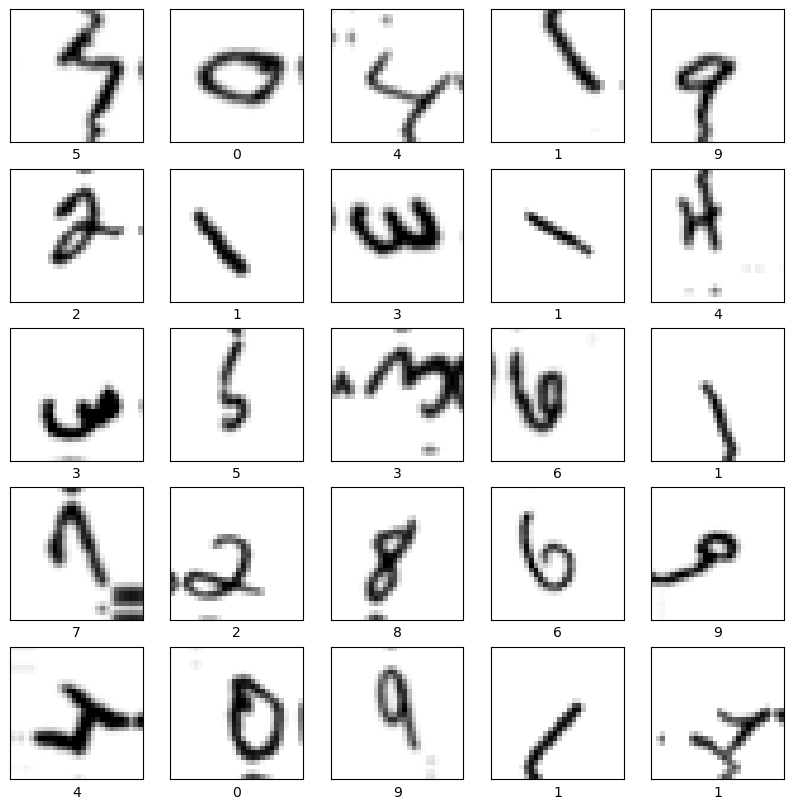

In [5]:
# Visualize the first 25 images of the train set
plt.figure(figsize=[10, 10])
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(train_labels[i])

plt.show()

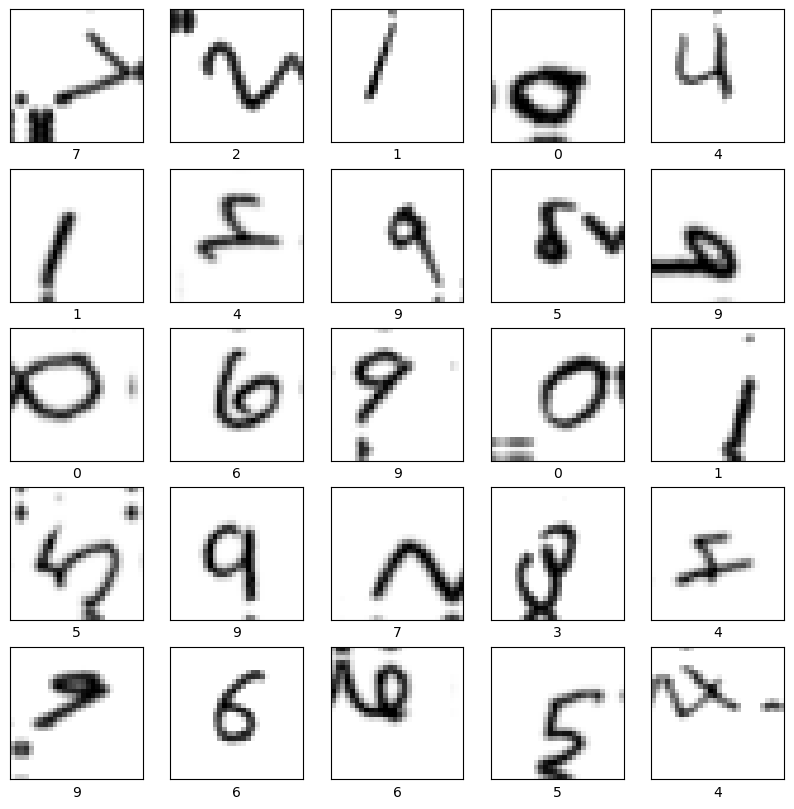

In [6]:
# Visualize the first 25 images of the test set
plt.figure(figsize=[10, 10])
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i], cmap=plt.cm.binary)
    plt.xlabel(test_labels[i])

plt.show()

## DNN model

### Prepare the data

Before building our DNN model, we need to prepare the images to go into the neural network. 
In this case, the images are reshaped into 2S arrays as DNN expects a 1D input vector.
As we have seen previously, the test set is not normalised so it is normalised here.
Lastly, the labels (Y) are passed to one-hot encoding

In [7]:
# Pre-format the images
train_images_dnn = train_images.astype("float32")
test_images_dnn = test_images.astype("float32")

num_pixels = train_images_dnn.shape[1] * train_images_dnn.shape[2]

# Flatten images
train_images_dnn = train_images_dnn.reshape(train_images_dnn.shape[0], num_pixels)
test_images_dnn = test_images_dnn.reshape(test_images_dnn.shape[0], num_pixels)

# Normalization
test_images_dnn /= 255

# One-hot encoding the target labels
num_classes = len(np.unique(train_labels))
train_labels_dnn = to_categorical(train_labels, num_classes)
test_labels_dnn = to_categorical(test_labels, num_classes)

### Build the model

The architecture of this model begins with an input layer that receives the flattened images

The first hidden layer features 256 neurons activated by the ReLU function and is followed by a second hidden layer with 128 neurons, also employing ReLU activation 

To mitigate the risk of overfitting, a dropout layer is introduced, randomly disabling 30% of the neurons during training

Finally, the output layer has the 10 expected classes and uses the softmax activation function to generate a probability distribution across these

The model is compiled with the RMSprop optimizer and categorical cross-entropy loss, allowing it to effectively learn from the data and optimize its performance based on accuracy metrics

In [8]:
def dense_model(num_pixels, num_classes):
    model = Sequential([
        Dense(256, activation='relu', input_dim=num_pixels),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer= optimizers.RMSprop(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Then use it like this:
model_dnn = dense_model(num_pixels, num_classes)
model_dnn.summary()


/opt/homebrew/Caskroom/miniconda/base/envs/aiao-env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [9]:
# Flatten the images
dnn_history = model_dnn.fit(train_images_dnn, train_labels_dnn, validation_split=0.3, epochs=50, batch_size=100)

Epoch 1/50
420/420 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2915 - loss: 1.9882 - val_accuracy: 0.5598 - val_loss: 1.3096
Epoch 2/50
420/420 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5822 - loss: 1.2510 - val_accuracy: 0.6548 - val_loss: 1.0804
Epoch 3/50
420/420 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6815 - loss: 0.9795 - val_accuracy: 0.6993 - val_loss: 0.9290
Epoch 4/50
420/420 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7344 - loss: 0.8217 - val_accuracy: 0.7427 - val_loss: 0.7887
Epoch 5/50
420/420 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7667 - loss: 0.7199 - val_accuracy: 0.7746 - val_loss: 0.7082
Epoch 6/50
420/420 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7884 - loss: 0.6486 - val_accuracy: 0.7883 - val_loss: 0.6750
Epoch 7/50
420/420 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8124 - loss: 0.5901 - val_accuracy: 0.7881 - val_loss: 0.6739
Epoch 8/50
420/420 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8253 - loss: 0.5368 - val_accuracy: 0.

### Evaluate the performance of the model

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - accuracy: 0.8076 - loss: 1.2417
Test accuracy: 0.8236


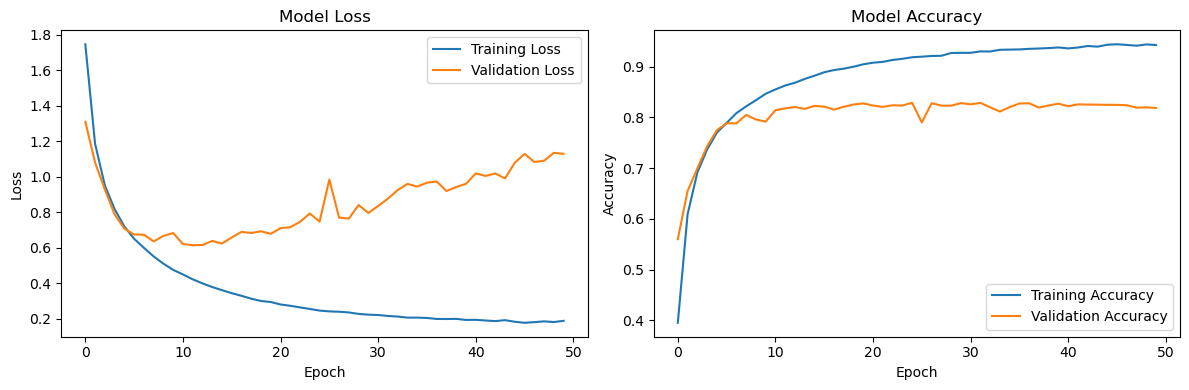

In [10]:
# Evaluate the model
test_loss_dnn, test_accuracy_dnn = model_dnn.evaluate(test_images_dnn, test_labels_dnn)
print(f"Test accuracy: {test_accuracy_dnn:.4f}")


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(dnn_history.history['loss'], label='Training Loss')
plt.plot(dnn_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(dnn_history.history['accuracy'], label='Training Accuracy')
plt.plot(dnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

The performance is quite good however the accuracy curves of the train and validation sets are quite separated, indicating some overfitting of the training set

In [11]:
# Save the model
# model_dnn.save('../res/model_dnn.h5')

## CNN model

### Prepare the data

In [12]:
# Pre-format the images
train_images_cnn = train_images.astype("float32")
test_images_cnn = test_images.astype("float32")

# Normalize
test_images_cnn /= 255

# Reshape to have a single channel (black & white)
train_images_cnn = train_images_cnn.reshape(train_images_cnn.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

# One hot encoding
num_classes = len(np.unique(train_labels))
train_labels_cnn = to_categorical(train_labels, num_classes)
test_labels_cnn = to_categorical(test_labels, num_classes)

# Shuffle the data
np.random.seed(0)
shuffle_index = np.random.permutation(train_images_cnn.shape[0])
train_images_cnn = train_images_cnn[shuffle_index]
train_labels_cnn = train_labels_cnn[shuffle_index]

### Build the model

In [13]:
def cnn_model(num_pixels, num_classes):
    model = Sequential([
        Conv2D(input_shape = train_images_cnn.shape[1:],
                filters = 32,
                kernel_size = (3,3),
                activation = "relu"),
        MaxPooling2D(pool_size = (2,2)),
        Conv2D(filters = 64,
                kernel_size = (3,3),
                activation = "relu"),
        MaxPooling2D(pool_size=(2,2)),
        Flatten(),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer = optimizers.RMSprop(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Then use it like this:
model_cnn = cnn_model(num_pixels, num_classes)
model_cnn.summary()


/opt/homebrew/Caskroom/miniconda/base/envs/aiao-env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │        16,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,826 (136.04 KB)

 Trainable params: 34,826 (136.04 KB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [14]:
cnn_history = model_cnn.fit(train_images_cnn, train_labels_cnn, 
                         validation_split=0.3, 
                         epochs=20, 
                         batch_size=100)

Epoch 1/20
420/420 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.3218 - loss: 1.9053 - val_accuracy: 0.5920 - val_loss: 1.2478
Epoch 2/20
420/420 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.6302 - loss: 1.1444 - val_accuracy: 0.6572 - val_loss: 1.0391
Epoch 3/20
420/420 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.7232 - loss: 0.8805 - val_accuracy: 0.7699 - val_loss: 0.7492
Epoch 4/20
420/420 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.7868 - loss: 0.6931 - val_accuracy: 0.7992 - val_loss: 0.6415
Epoch 5/20
420/420 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.8258 - loss: 0.5731 - val_accuracy: 0.8126 - val_loss: 0.6050
Epoch 6/20
420/420 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.8516 - loss: 0.4932 - val_accuracy: 0.8427 - val_loss: 0.5073
Epoch 7/20
420/420 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.8669 - loss: 0.4393 - val_accuracy: 0.8508 - val_loss: 0.4808
Epoch 8/20
420/420 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.8810 - loss: 0.3949 - val_accu

### Evaluate the performance of the model

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9031 - loss: 0.3340
Test accuracy: 0.9133


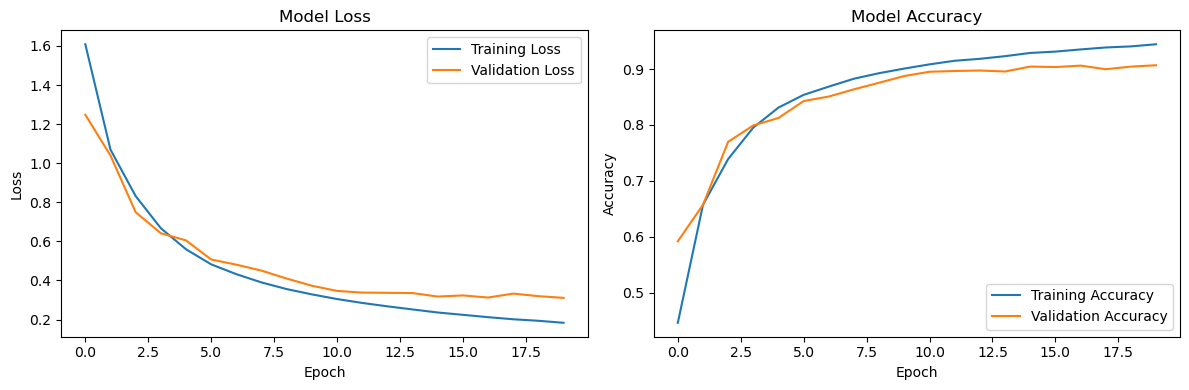

In [15]:
# Evaluate the model
test_loss_cnn, test_accuracy_cnn = model_cnn.evaluate(test_images_cnn, test_labels_cnn)
print(f"Test accuracy: {test_accuracy_cnn:.4f}")


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['loss'], label='Training Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['accuracy'], label='Training Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

We can observe a global improvement compared to the DNN

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


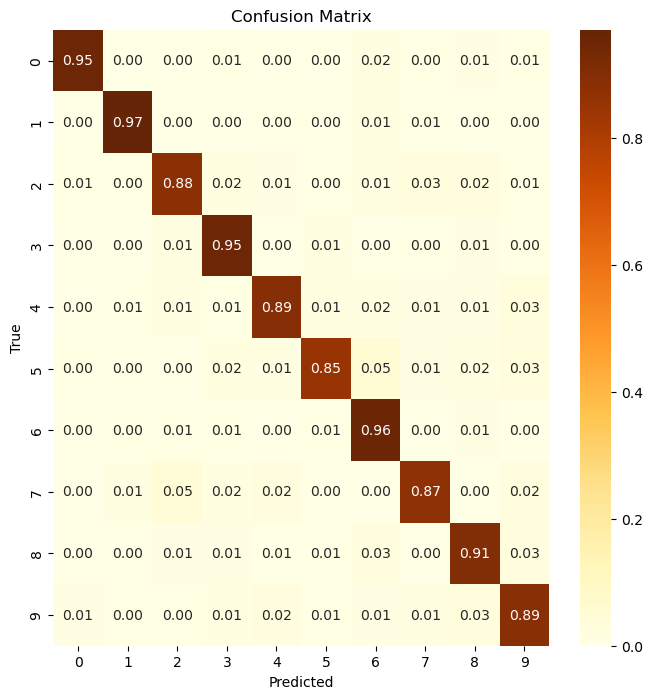

In [16]:
# Make predictions
labs_pred_proba = model_cnn.predict(test_images_cnn)

# Convert one-hot encoded labels back to class indices
lab_test_classes = np.argmax(test_labels_cnn, axis = 1)
lab_pred_classes = np.argmax(labs_pred_proba, axis = 1)

# Create confusion matrix
cm = confusion_matrix(lab_test_classes, lab_pred_classes, normalize='true')

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='YlOrBr')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [17]:
# Save the model
# model_cnn.save('../res/model_cnn.h5')

## CNN model - optim.

### Build the model

In [18]:
def cnn_model_optim(num_pixels, num_classes):
    model = Sequential([
        Conv2D(input_shape = train_images_cnn.shape[1:],
                filters = 32,
                kernel_size = (3,3),
                activation = "relu"),
        MaxPooling2D(pool_size = (2,2)),
        Conv2D(filters = 64,
                kernel_size = (3,3),
                activation = "relu"),
        MaxPooling2D(pool_size = (2,2)),
        Dropout(0.25),
        Flatten(),
        Dense(units = 128,
                activation = "relu"),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=optimizers.RMSprop(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Then use it like this:
model_cnn_optim = cnn_model_optim(num_pixels, num_classes)
model_cnn_optim.summary()


/opt/homebrew/Caskroom/miniconda/base/envs/aiao-env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [19]:
cnn_optim_history = model_cnn_optim.fit(train_images_cnn, train_labels_cnn, 
                         validation_split=0.3, 
                         epochs=20, 
                         batch_size=100)

Epoch 1/20
420/420 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.3684 - loss: 1.7855 - val_accuracy: 0.7419 - val_loss: 0.8267
Epoch 2/20
420/420 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.7619 - loss: 0.7570 - val_accuracy: 0.8649 - val_loss: 0.4506
Epoch 3/20
420/420 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.8510 - loss: 0.4777 - val_accuracy: 0.9047 - val_loss: 0.3234
Epoch 4/20
420/420 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.8936 - loss: 0.3530 - val_accuracy: 0.9175 - val_loss: 0.2717
Epoch 5/20
420/420 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.9162 - loss: 0.2721 - val_accuracy: 0.9270 - val_loss: 0.2400
Epoch 6/20
420/420 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.9274 - loss: 0.2355 - val_accuracy: 0.9324 - val_loss: 0.2197
Epoch 7/20
420/420 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.9380 - loss: 0.1997 - val_accuracy: 0.9351 - val_loss: 0.2114
Epoch 8/20
420/420 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.9436 - loss: 0.1736 - val_accu

### Evaluate the performance of the model

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9488 - loss: 0.2037
Test accuracy: 0.9575


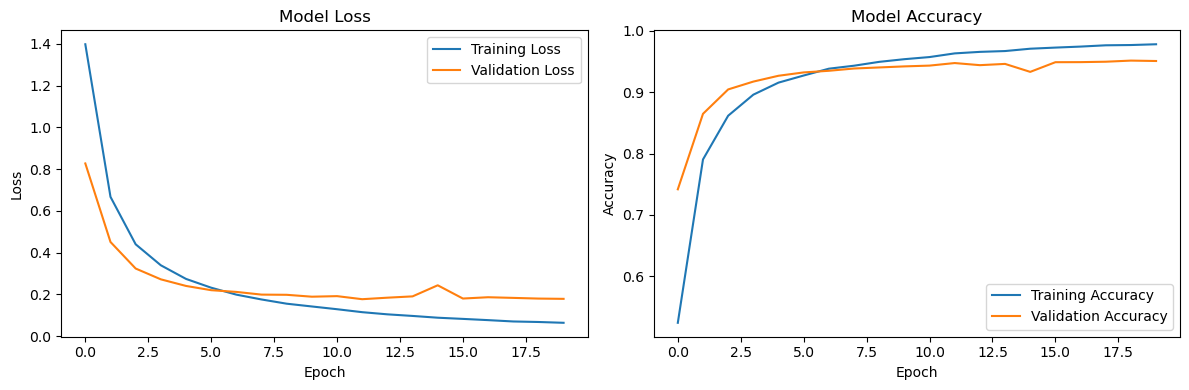

In [20]:
# Evaluate the model
test_loss_cnn_optim, test_accuracy_cnn_optim = model_cnn_optim.evaluate(test_images_cnn, test_labels_cnn)
print(f"Test accuracy: {test_accuracy_cnn_optim:.4f}")


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(cnn_optim_history.history['loss'], label='Training Loss')
plt.plot(cnn_optim_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cnn_optim_history.history['accuracy'], label='Training Accuracy')
plt.plot(cnn_optim_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

Compared with the previous CNN, the implementation of the normalisation and the last dense layer did have an effect on the accuracy, as it has increased and the curves are similar

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


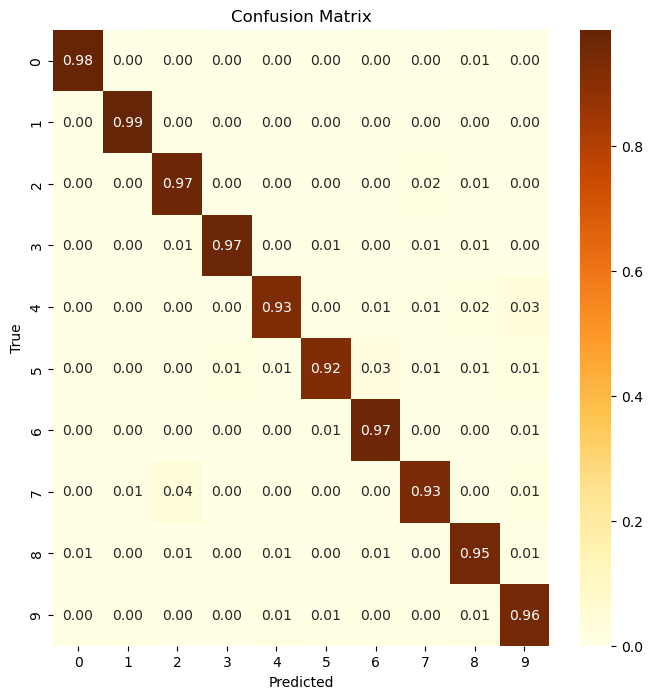

In [21]:
# Make predictions
labs_pred_proba = model_cnn_optim.predict(test_images_cnn)

# Convert one-hot encoded labels back to class indices
lab_test_classes = np.argmax(test_labels_cnn, axis = 1)
lab_pred_classes = np.argmax(labs_pred_proba, axis = 1)

# Create confusion matrix
cm = confusion_matrix(lab_test_classes, lab_pred_classes, normalize='true')

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='YlOrBr')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [22]:
# Save the model
# model_cnn_optim.save('../res/model_cnn_opt.h5')

## Comparison

Table of Accuracy Values:


,Model,Accuracy
0,DNN,0.8236
1,CNN,0.9133
2,CNN_Optim,0.9575


/var/folders/2r/vz71dl552fd4t6lk1z7s6_bh0000gn/T/ipykernel_39537/3126875733.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Model', y='Accuracy', data=df, palette=colors)


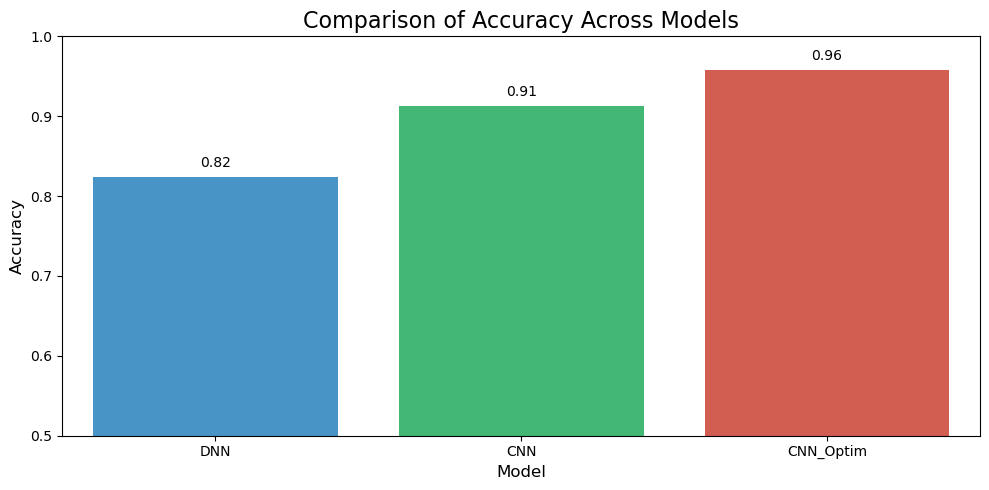

In [23]:
data = {
    'Model': ['DNN', 'CNN', 'CNN_Optim'],
    'Accuracy': [test_accuracy_dnn, test_accuracy_cnn, test_accuracy_cnn_optim]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Display the table
print("Table of Accuracy Values:")
display(df.style.format({"Accuracy": "{:.4f}"}))

# Function to add value labels on bars
def add_value_labels(ax, spacing=5):
    for rect in ax.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        label = f"{y_value:.2f}"
        
        ax.annotate(label, (x_value, y_value), xytext=(0, spacing),
                    textcoords="offset points", ha='center', va='bottom')

colors = ['#3498db', '#2ecc71', '#e74c3c']

plt.figure(figsize=(10, 5))
ax = sns.barplot(x='Model', y='Accuracy', data=df, palette=colors)
plt.title('Comparison of Accuracy Across Models', fontsize=16)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0.5, 1.0)
add_value_labels(ax)
plt.tight_layout()
plt.show()


## Evaluation of the best model with cross-validation

In [24]:
training = KerasClassifier(build_fn=model_cnn_optim,
                           epochs=20, batch_size=100, verbose=0)

kfold = KFold(n_splits=5, shuffle=True)

cv_results = cross_val_score(training, train_images_cnn, 
                             train_labels_cnn, cv=kfold)

/opt/homebrew/Caskroom/miniconda/base/envs/aiao-env/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/Caskroom/miniconda/base/envs/aiao-env/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/Caskroom/miniconda/base/envs/aiao-env/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/Caskroom/miniconda/base/envs/aiao-env/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` i

In [25]:
print("Cross validation accuracies:", cv_results)
print("Results Cross validation : %.2f%% (%.2f%%)"%(cv_results.mean()*100, cv_results.std()*100))

Cross validation accuracies: [0.9655  0.97025 0.97075 0.972   0.9735 ]
Results Cross validation : 97.04% (0.27%)
